# Notebook for model training analysis

Imports

In [3]:
import time
import os
import importlib

from pprint import pprint
from collections import defaultdict
from pathlib import Path
from more_itertools import grouper
from itertools import islice, chain, zip_longest, repeat

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy import io
from scipy.signal import convolve
from scipy.sparse import coo_matrix, csr_matrix
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import cut_tree

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

from Modules import utils, plot_utils

Useful global variables

In [4]:
importlib.reload(utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

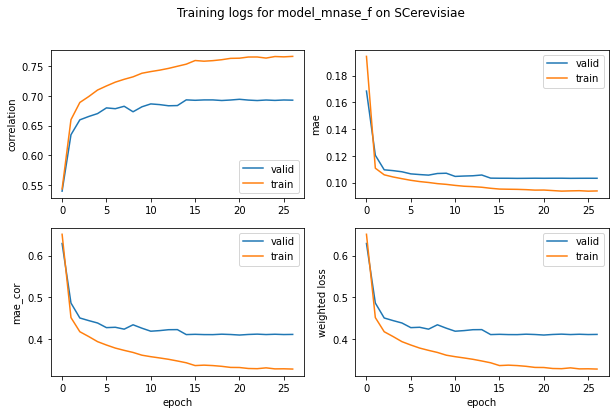

In [31]:
data = 'SCerevisiae'
model_name = 'model_mnase_f'

logs = pd.read_csv(Path(data_dir, data, 'Trainedmodels', model_name, 'epoch_data.csv'))
fig = plt.figure(figsize=(10, 6))
fig.suptitle(f'Training logs for {model_name} on {data}')
ax0 = plt.subplot(221)
ax0.plot(logs['val_correlate'], label='valid')
ax0.plot(logs['correlate'], label='train')
ax0.set_ylabel('correlation')
ax0.legend()

ax1 = plt.subplot(222)
ax1.plot(logs['val_mae'], label='valid')
ax1.plot(logs['mae'], label='train')
ax1.set_ylabel('mae')
ax1.legend()

ax2 = plt.subplot(223)
ax2.plot(logs['val_mae'] + 1 - logs['val_correlate'], label='valid')
ax2.plot(logs['mae'] + 1 - logs['correlate'], label='train')
ax2.set_xlabel('epoch')
ax2.set_ylabel('mae_cor')
ax2.legend()

ax3 = plt.subplot(224)
ax3.plot(logs['val_loss'], label='valid')
ax3.plot(logs['loss'], label='train')
ax3.set_xlabel('epoch')
ax3.set_ylabel('weighted loss')
ax3.legend()

fig_file = Path(writing_dir, data, 'results', model_name, f'{model_name}_train_log.png')
fig_file = utils.safe_filename(fig_file)
plt.savefig(fig_file, bbox_inches='tight')
plt.show()
plt.close()

In [32]:
import pyBigWig

In [46]:
data = 'SCerevisiae'
model_name = 'model_mnase_21'
chr_id = 'chr16'
with np.load(Path(data_dir, data, 'results', model_name, 'preds_on_W303.npz')) as f:
    pred_test = f[chr_id]
    pred_test_rev = f[f'{chr_id}_rev']
with np.load(Path(data_dir, data, 'data', 'processed_MNase.npz')) as f:
    y_test = f[chr_id]
bw = pyBigWig.open(str(Path(data_dir, data, 'data', 'Yeast-myco_MNase_exp.bw')))
true_y = bw.values('chrXVI', 0, -1, numpy=True)
del bw
np.corrcoef([true_y, y_test, pred_test, pred_test_rev])

array([[1.        , 0.67019444, 0.46101179, 0.46003341],
       [0.67019444, 1.        , 0.71519793, 0.71357403],
       [0.46101179, 0.71519793, 1.        , 0.9301446 ],
       [0.46003341, 0.71357403, 0.9301446 , 1.        ]])

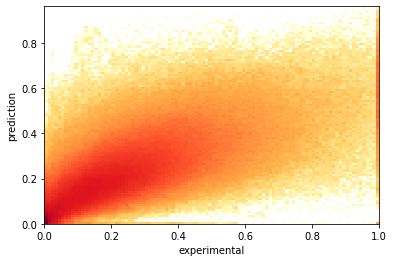

In [17]:
plt.hist2d(y_test, pred_test, bins=100, norm=mpl.colors.LogNorm(), cmap='YlOrRd')
plt.xlabel('experimental')
plt.ylabel('prediction')
plt.show()
plt.close()

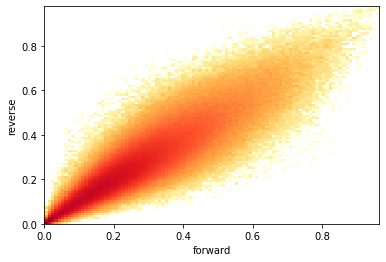

In [18]:
plt.hist2d(pred_test, pred_test_rev, bins=100, norm=mpl.colors.LogNorm(), cmap='YlOrRd')
plt.xlabel('forward')
plt.ylabel('reverse')
plt.show()
plt.close()

Plot test distribution

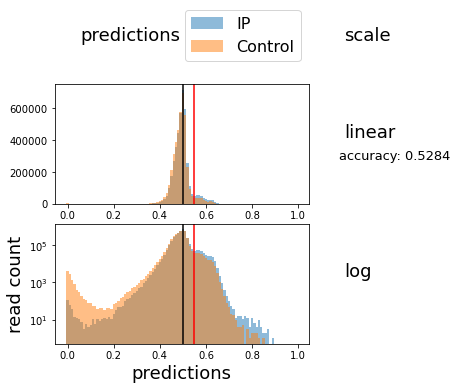

In [4]:
data = 'Judith-H3K9me3'
dataset_name = 'sharded_dataset2'
model_name = 'model_inception3.1'
sharded = True
part = 'test'
thres = 0.55 # None # threshold to visualize in figure
# Get predictions and labels
with np.load(Path(data_dir, data, 'results', model_name, f'distrib_{model_name}_{part}.npz')) as f:
    preds = f['pred']
if sharded:
    y_part = np.zeros(len(preds), dtype=bool)
    y_part[::2] = 1
else:
    with np.load(Path(data_dir, data, f'{dataset_name}.npz')) as f:
        y_part = f[f'y_{part}']
# Isolate labels and compute accuracy
predIP = preds[y_part == 1]
predControl = preds[y_part == 0]
accuracy = (len(predIP[predIP > 0.5]) + len(predControl[predControl < 0.5])) / (len(predIP) + len(predControl))
# Build histogram
n_bins = 100
histIP, bins = np.histogram(predIP, bins=n_bins, range=(0, 1))
histControl = np.histogram(predControl, bins=n_bins, range=(0, 1))[0]

# Build figure
widths = [5, 1]
heights = [1.2] + [2.5]*2
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} on {data}-{dataset}-{part} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)
# Top labels
ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'predictions'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'scale'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

for nrow in range(1,3):
    ax0 = plt.subplot(gs[nrow, 0])
    # Histograms
    ax0.bar(bins[:-1], histIP, width=np.diff(bins), label='IP', alpha=0.5)
    ax0.bar(bins[:-1], histControl, width=np.diff(bins), label='Control', alpha=0.5)
    # Vertical lines
    ax0.axvline(x=0.5, color='black')#, label='t0.5')
    if thres is not None:
        ax0.axvline(x=thres, color='red')#, label=f't{thres}')
    # Right labels and scale adjustment
    ax1 = plt.subplot(gs[nrow, 1])
    if nrow == 1:
        label = 'linear'
        ax1.annotate(f'accuracy: {round(accuracy, 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    elif nrow == 2:
        label = 'log'
        ax0.set_yscale('log')
    ax1.annotate(label, (0.1, 0.6), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')
ax0.set_xlabel("predictions", fontsize=18)
ax0.set_ylabel("read count", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right', fontsize=16)
# Save figure
fig_file = Path(writing_dir, data, 'results', model_name, f'distrib_{model_name}_{part}.png')
fig_file = utils.safe_filename(fig_file)
plt.savefig(fig_file, bbox_inches='tight')
# Save histogram
# np.savez(Path(writing_dir, data, 'results', model_name, f'distrib_{model_name}_{part}_hist{n_bins}'), IP=histIP, Control=histControl)
plt.show()
plt.close()

Select sequences

In [5]:
# thres = 0.6
if sharded:
    with np.load(Path(data_dir, data, dataset_name, 'test_0.npz')) as f:
        ids_test = f['ids']
        # x_test = f['one_hots']
    selected_ids = ids_test[preds.ravel() > thres]
    # selected_reads = x_test[preds.ravel() < thres, :, :]
    print(f'nb of selected reads with thres {thres}:', len(selected_ids))
    with open(Path(data_dir, data, 'results', model_name, f'read_ids_{data}_over_{thres}_with_{model_name}.txt'), 'w') as f:
        for read_id in selected_ids:
            f.write(read_id[1:])
            f.write('\n')
else:
    with np.load(Path(data_dir, data, f'{dataset_name}.npz')) as f:
        x_test = f['x_test']
    selected_reads = x_test[preds.ravel() < thres, :, :]
    print(f'nb of selected reads with thres {thres}:', len(selected_reads))

nb of selected reads with thres 0.55: 647415


In [ ]:
with np.load(Path(data_dir, data, f'{dataset_name}.npz')) as f:
    x_test = f['x_test']
thres0 = 0.83
thres1 = 0.99
preds = preds.ravel()
mask = np.logical_and(preds > thres0, preds < thres1)
selected_reads = x_test[mask, :, :]
print(f'nb of selected reads between {thres0} and {thres1}:', len(selected_reads))

Write into fasta file

In [6]:
# 3m per 10_000_000 seqs of 101 bp
utils.write_fasta(utils.one_hot_to_seq(selected_reads), Path(writing_dir, data, 'results', model_name, f'seqs_{data}_over_{thres}_with_{model_name}.fasta'))

In [ ]:
# 3m per 10_000_000 seqs of 101 bp
utils.write_fasta(utils.one_hot_to_seq(selected_reads), Path(writing_dir, data, 'results', model_name, f'seqs_{data}_over_{thres0}_below_{thres1}_with_{model_name}.fasta'))

Plot training logs

KeyError: 'val_accuracy'

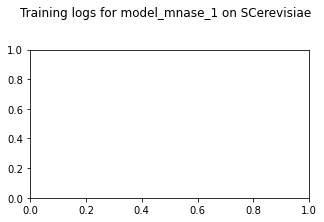

In [3]:
logs = pd.read_csv(Path(data_dir, data, 'Trainedmodels', model_name, 'epoch_data.csv'))
fig = plt.figure(figsize=(5, 6))
fig.suptitle(f'Training logs for {model_name} on {data}')
ax0 = plt.subplot(211)
ax0.plot(logs['val_accuracy'], label='valid')
ax0.plot(logs['accuracy'], label='train')
ax0.set_ylabel('accuracy')
ax0.legend()

ax1 = plt.subplot(212)
ax1.plot(logs['val_loss'], label='valid')
ax1.plot(logs['loss'], label='train')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()

fig_file = Path(writing_dir, data, 'results', model_name, f'{model_name}_train_log.png')
fig_file = utils.safe_filename(fig_file)
plt.savefig(fig_file, bbox_inches='tight')
plt.show()
plt.close()

In [20]:
IP_accuracy = len(predIP[predIP > 0.5]) / len(predIP)
Control_accuracy = len(predControl[predControl < 0.5]) / len(predControl)
print('accuracy: ', accuracy)
print('IP accuracy: ', IP_accuracy)
print('Control accuracy: ', Control_accuracy)
print('diff:', IP_accuracy - Control_accuracy)

accuracy:  0.554107666015625
IP accuracy:  0.5899467468261719
Control accuracy:  0.5182685852050781
diff: 0.07167816162109375


Plot test distribution during epochs

maximum accuracy of 0.5088714361190796 on epoch 17


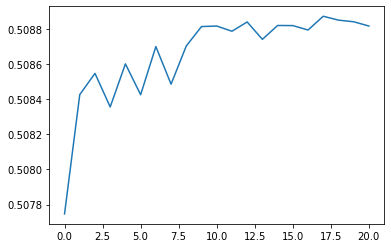

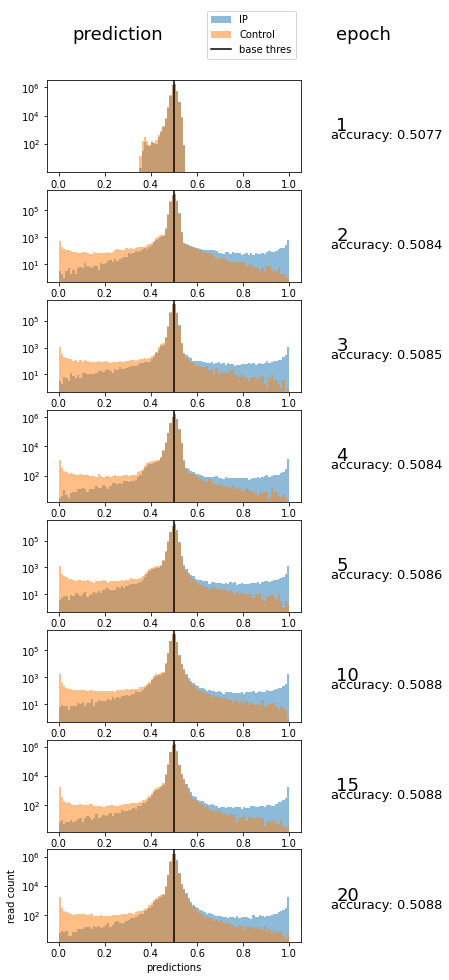

In [36]:
data = 'H3K9me3-GSE175752'
dataset_name = 'sharded_dataset'
model_name = 'model_inception3.0'
sharded = True
preds = np.load(Path(data_dir, data, 'Trainedmodels', model_name, 'eval_epochs.npy'))
if sharded:
    y_test = np.zeros(preds.shape[1], dtype=bool)
    y_test[::2] = 1
else:
    with np.load(Path(data_dir, data, f'{dataset_name}.npz')) as f:
        y_test = f['y_test']

predsIP = preds[:, y_test == 1]
predsControl = preds[:, y_test == 0]
correct_IP = (predsIP > 0.5)
correct_Control = (predsControl < 0.5)
accuracys = (np.sum(correct_IP, axis=1) + np.sum(correct_Control, axis=1)) / len(y_test)
amax = np.argmax(accuracys)
print(f'maximum accuracy of {accuracys[amax]} on epoch {amax}')
plt.plot(accuracys)
plt.show()
plt.close()

# epochs = range(0, preds.shape[0], 5)
epochs = [0, 1, 2, 3, 4, 9, 14, 19]
widths = [5, 1]
heights = [1.2] + [2]*len(epochs)
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} during epochs on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'prediction'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'epoch'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

nrow = 1
for epoch in epochs:
    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(predsIP[epoch], bins=100, label='IP', alpha=0.5, range=(0,1))
    ax0.hist(predsControl[epoch], bins=100, label='Control', alpha=0.5, range=(0,1))
    ax0.axvline(x=0.5, color='black', label='base thres')
    ax0.set_yscale('log')

    ax1 = plt.subplot(gs[nrow, 1])
    label = f'{epoch+1}'
    ax1.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
    ax1.annotate(f'accuracy: {round(accuracys[epoch], 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    ax1.axis('off')

    nrow += 1

handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')
ax0.set_xlabel("predictions")
ax0.set_ylabel("read count")
fig_file = Path(writing_dir, data, 'results', model_name, f'distrib_{model_name}_test_epochs.png')
fig_file = utils.safe_filename(fig_file)
plt.savefig(fig_file, bbox_inches='tight')
plt.show()
plt.close()

Compare predictions between 2 models

In [ ]:
data = 'Judith-H3K4me3'
dataset_name = 'dataset4'
model_name = 'model_inception2.2_rel8'
model_name2 = 'model_inception2.2'
new_labels = 'dataset_rel8'
relabeled = True
preds = np.load(Path(data_dir, data, 'Trainedmodels', model_name, 'eval_epochs.npy'))
preds2 = np.load(Path(data_dir, data, 'Trainedmodels', model_name2, 'eval_epochs.npy'))
min_len = min(len(preds), len(preds2))
diff = preds[:min_len] - preds2[:min_len]

if relabeled:
    with np.load(Path(data_dir, data, f'{new_labels}.npz')) as f:
        y_test = f['y_test']
else:
    with np.load(Path(data_dir, data, f'{dataset_name}.npz')) as f:
        y_test = f['y_test']

diffIP = diff[:, y_test == 1]
diffControl = diff[:, y_test == 0]

# epochs = range(0, preds.shape[0], 5)
epochs = [0, 1, 2, 3, 4, 9, 14, 19]
widths = [5, 1]
heights = [1.2] + [2]*len(epochs)
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of prediction differences of {model_name} during epochs on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'prediction difference'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'epoch'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

nrow = 1
for epoch in epochs:
    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(diffIP[epoch], bins=100, label='IP', alpha=0.5, range=(-1, 1))
    ax0.hist(diffControl[epoch], bins=100, label='Control', alpha=0.5, range=(-1, 1))
    # ax0.set_yscale('log')

    ax1 = plt.subplot(gs[nrow, 1])
    label = f'{epoch+1}'
    ax1.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')

    nrow += 1

handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')
ax0.set_xlabel("difference")
ax0.set_ylabel("read count")
fig_file = Path(writing_dir, data, 'results', model_name, f'distrib_{model_name}_vs_{model_name2}_test_epochs.png')
fig_file = safe_filename(fig_file)
plt.savefig(fig_file, bbox_inches='tight')
plt.show()
plt.close()

## Other analysis on data

Plot GC_content distribution

accuracy : 0.5104131698608398


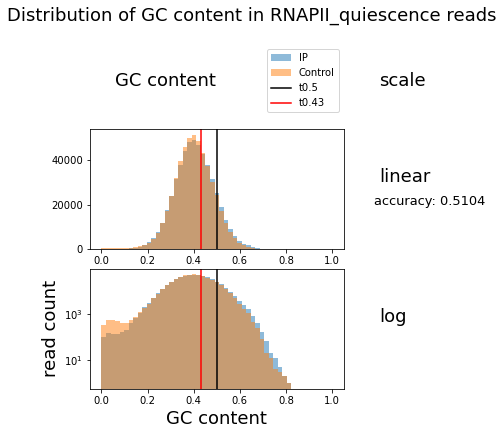

In [11]:
data='RNAPII_quiescence'
dataset_name='sharded_dataset_6d_0.01'
sharded = True
if sharded:
    with np.load(Path(data_dir, data, dataset_name, 'test_0.npz')) as f:
        x_test = f['one_hots']
    y_test = np.zeros(len(x_test), dtype=bool)
    y_test[::2] = 1
else:
    with np.load(Path(data_dir, data, f'{dataset_name}.npz')) as f:
        x_test = f['x_test']
        y_test = f['y_test']
gc_content = utils.GC_content(x_test)

bins = np.histogram(gc_content, bins=51, range=(0, 1))[1]
accuracy, thres = utils.classify_1D(gc_content, y_test, bins=75)
print('accuracy :', accuracy)

widths = [5, 1]
heights = [1.2] + [2.5]*2
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'GC content'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'scale'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

for nrow in range(1,3):

    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(gc_content[y_test == 1], bins, label='IP', alpha=0.5)
    ax0.hist(gc_content[y_test == 0], bins, label='Control', alpha=0.5)
    ax0.axvline(x=0.5, color='black', label=f't0.5')
    ax0.axvline(x=thres, color='red', label=f't{round(thres, 2)}')
    
    ax1 = plt.subplot(gs[nrow, 1])
    if nrow == 1:
        scale_label = 'linear'
        ax1.annotate(f'accuracy: {round(accuracy, 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    elif nrow == 2:
        scale_label = 'log'
        ax0.set_yscale('log')
    ax1.annotate(scale_label, (0.1, 0.6), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')
ax0.set_xlabel("GC content", fontsize=18)
ax0.set_ylabel("read count", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')

fig.suptitle(f'Distribution of GC content in {data} reads', fontsize=18)
fig_name = Path(writing_dir, data, 'results', f'gc_content_classification_{dataset_name}.png')
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

Old script for plot test distribution (too many cases)

In [ ]:
data = 'Judith-H3K4me3'
dataset_name = 'sharded_dataset2'
model_name = 'model_inception3.1'
load_hist = False
hist_file = f'distrib_{model_name}_test_hist100000'
relabeled = False
new_labels = 'dataset_rel8'
single_pred_array = True
sharded = True
if load_hist:
    with np.load(f'{writing_dir}/{data}/results/{model_name}/{hist_file}.npz') as f:
        histIP = f['IP']
        histControl = f['Control']
    bins = np.linspace(0, 1, len(histIP)+1)
    win_start = 80000
    win_stop = 80100
    histIP, histControl, bins = histIP[win_start:win_stop], histControl[win_start:win_stop], bins[win_start:win_stop+1]
else:
    if single_pred_array:
        if relabeled:
            with np.load(f'{data_dir}/{data}/results/{model_name}/distrib_{model_name}_test.npz') as f:
                preds = f['pred']
            with np.load(f'{data_dir}//{data}/{new_labels}.npz') as f:
                y_test = f['y_test']
        else:
            with np.load(f'{data_dir}/{data}/results/{model_name}/distrib_{model_name}_test.npz') as f:
                preds = f['pred']
            if sharded:
                y_test = np.zeros(len(preds), dtype=bool)
                y_test[::2] = 1
            else:
                with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
                    y_test = f['y_test']
        predIP = preds[y_test == 1]
        predControl = preds[y_test == 0]
    else:
        with np.load(f'{data_dir}/{data}/results/distrib_{model_name}_test.npz') as f:
                predIP = f['predIP']
                predControl = f['predControl']
    accuracy = (len(predIP[predIP > 0.5]) + len(predControl[predControl < 0.5])) / (len(predIP) + len(predControl))
    n_bins = 100
    histIP, bins = np.histogram(predIP, bins=n_bins, range=(0, 1))
    histControl = np.histogram(predControl, bins=n_bins, range=(0, 1))[0]

widths = [5, 1]
heights = [1.2] + [2.5]*2
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'predictions'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'scale'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

for nrow in range(1,3):

    ax0 = plt.subplot(gs[nrow, 0])

    ax0.bar(bins[:-1], histIP, width=np.diff(bins), label='IP', alpha=0.5)
    ax0.bar(bins[:-1], histControl, width=np.diff(bins), label='Control', alpha=0.5)

    if not load_hist:
        ax0.axvline(x=0.5, color='black')#, label='t0.5')
        thres = 0.6
        ax0.axvline(x=thres, color='red')#, label=f't{thres}')
    
    ax1 = plt.subplot(gs[nrow, 1])
    if nrow == 1:
        label = 'linear'
        if not load_hist:
            ax1.annotate(f'accuracy: {round(accuracy, 2)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    elif nrow == 2:
        label = 'log'
        ax0.set_yscale('log')
    ax1.annotate(label, (0.1, 0.6), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')
ax0.set_xlabel("predictions", fontsize=18)
ax0.set_ylabel("read count", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right', fontsize=16)

if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.makedirs(f'{writing_dir}/{data}/results/{model_name}')
fig_start = f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test'
fig_name = fig_start + '.png'
fig_dups = 0
while os.path.exists(fig_name):
    fig_dups += 1
    fig_name = fig_start + f'({fig_dups}).png'
plt.savefig(fig_name, bbox_inches='tight')
if not load_hist:
    np.savez(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test_hist{n_bins}', IP=histIP, Control=histControl)
plt.show()
plt.close()

Old script for plot test distribution during epochs

In [ ]:
data = 'H3K9me3-GSE175752'
dataset_name = 'sharded_dataset'
model_name = 'model_inception3.0'
new_labels = 'dataset_rel8'
relabeled = False
sharded = True
preds = np.load(f'{data_dir}/{data}/Trainedmodels/{model_name}/eval_epochs.npy')
# Watching for nan predictions
# for epoch in range(preds.shape[0]):
#     nans = np.count_nonzero(np.isnan(preds[epoch]))
#     print(f'Epoch {epoch}: {nans} nan predictions')
if relabeled:
    with np.load(f'{data_dir}/{data}/{new_labels}.npz') as f:
        y_test = f['y_test']
else:
    if sharded:
        y_test = np.zeros(preds.shape[1], dtype=bool)
        y_test[::2] = 1
    else:
        with np.load(f'{data_dir}//{data}/{dataset_name}.npz') as f:
            y_test = f['y_test']


predsIP = preds[:, y_test == 1]
predsControl = preds[:, y_test == 0]
correct_IP = (predsIP > 0.5)
correct_Control = (predsControl < 0.5)
accuracys = (np.sum(correct_IP, axis=1) + np.sum(correct_Control, axis=1)) / len(y_test)
amax = np.argmax(accuracys)
print(amax)
print(accuracys[amax])
plt.plot(accuracys)
plt.show()
plt.close()

# epochs = range(0, preds.shape[0], 5)
epochs = [0, 1, 2, 3, 4, 9, 14, 19]
widths = [5, 1]
heights = [1.2] + [2]*len(epochs)
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} during epochs on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'prediction'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'epoch'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

nrow = 1
for epoch in epochs:
    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(predsIP[epoch], bins=100, label='IP', alpha=0.5, range=(0,1))
    ax0.hist(predsControl[epoch], bins=100, label='Control', alpha=0.5, range=(0,1))
    ax0.axvline(x=0.5, color='black', label='base thres')
    ax0.set_yscale('log')

    ax1 = plt.subplot(gs[nrow, 1])
    label = f'{epoch+1}'
    ax1.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
    ax1.annotate(f'accuracy: {round(accuracys[epoch], 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    ax1.axis('off')

    nrow += 1

handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')
ax0.set_xlabel("predictions")
ax0.set_ylabel("read count")
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.makedirs(f'{writing_dir}/{data}/results/{model_name}/')
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test_epochs.png', bbox_inches='tight')
plt.show()
plt.close()

## Code for selected reads in H3K27me3

In [65]:
s = 'ATCGGAAGAGCGTCGTGTAGGGAA (AATGATACGGCGA) CCACCGAGATCTACACCCTT TCGCCGTATCATTAAAAAAAAA'
mots = s.split()
print(len(mots[0]+mots[2]+mots[3]))
print(len(s)-5)

66
79


In [16]:
with open('../shared_folder/H3K27me3/results/model_inception2.2/seqs_H3K27me3_over_0.8_with_model_inception2.2.fasta') as file:
    seqs = []
    seq = ''
    for line in file:
        if line.startswith('>'):
            if seq != '':
                seqs.append(seq)
                seq = ''
        else:
            seq += line.rstrip()
    if seq != '':
        seqs.append(seq)

In [24]:
selected = []
for seq in seqs:
    if not('ATCGGAAGAGCGTCGTGTAGG' in seq or 'CGGTGGTCGCCGTATCATTAAAAAAAAA' in seq):
        selected.append(seq)
print(len(selected))
# selected = []
# for seq in seqs:
#     if 'ATCGGAAGAGC' not in seq or 'GTCGTGTAGG' not in seq or 'CGGTGGTCGCCGTATCATTAAAAAAAAA' not in seq:
#         selected.append(seq)
# print(len(selected))

33539


In [22]:
utils.write_fasta(selected, '../shared_folder/H3K27me3/results/model_inception2.2/seqs_H3K27me3_over_0.8_with_model_inception2.2_filtered.fasta')